#### The purpose of this notebooks is to test whether the single trial beta maps produce a similar maps as the SPM univariate analysis

Method:
* 1) convert .nii to .npy : scripts/step10_nilearn/glm/cue-high_GT_cue-low/glm_numpify_ttest.py
* 2) average .npy per subject (session and run concatenated): scripts/step10_nilearn/glm/cue-high_GT_cue-low/numpy_ttest_cue.py
* 3) plot the end product here.

In [8]:
import numpy as np
import glob
import os
import pathlib
import re
import statsmodels 
from statsmodels.stats import multitest
import scipy
import nilearn
from scipy import stats
from nilearn.image import resample_to_img, math_img
from nilearn import image
from nilearn import plotting
import argparse
from nilearn.image import new_img_like
import matplotlib.pyplot as plt


In [16]:
# load group data
beta_dir =  '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy'
suballLv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_event-stimulus_cuetype-low.npy"))
suballHv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_event-stimulus_cuetype-high.npy"))

In [29]:
print(suballLv.shape) # 109 participants, (73, 86, 73) brain shape
print(suballHv.shape) # 109 participants, (73, 86, 73) brain shape

(109, 458294)
(109, 458294)


In [24]:
# create mask from canlab mask. Use sample single trial as target shape/affine
imgfname = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0060/sub-0060_ses-01_run-05_runtype-vicarious_event-stimulus_trial-011_cuetype-low_stimintensity-low.nii.gz'
ref_img = image.load_img(imgfname)

mask = image.load_img('/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii')
mask_img = nilearn.masking.compute_epi_mask(mask, target_affine = ref_img.affine, target_shape = ref_img.shape)

nifti_masker = nilearn.maskers.NiftiMasker(mask_img= mask_img,
                                           smoothing_fwhm=6,
                            target_affine = ref_img.affine, target_shape = ref_img.shape, 
                    memory="nilearn_cache", memory_level=1)

In [25]:
# apply mask to each average numpy (shape: subjects x voxels)
        
x,y,z=ref_img.shape
H = []
L = []
for index in range(suballHv.shape[0]):

    H.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballHv[index].reshape(x,y,z)))
    )
    L.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballLv[index].reshape(x,y,z)))
    )

In [26]:
fmri_masked_stimhigh = np.vstack(H)
fmri_masked_stimlow = np.vstack(L)
print(fmri_masked_stimlow.shape)

(109, 98053)


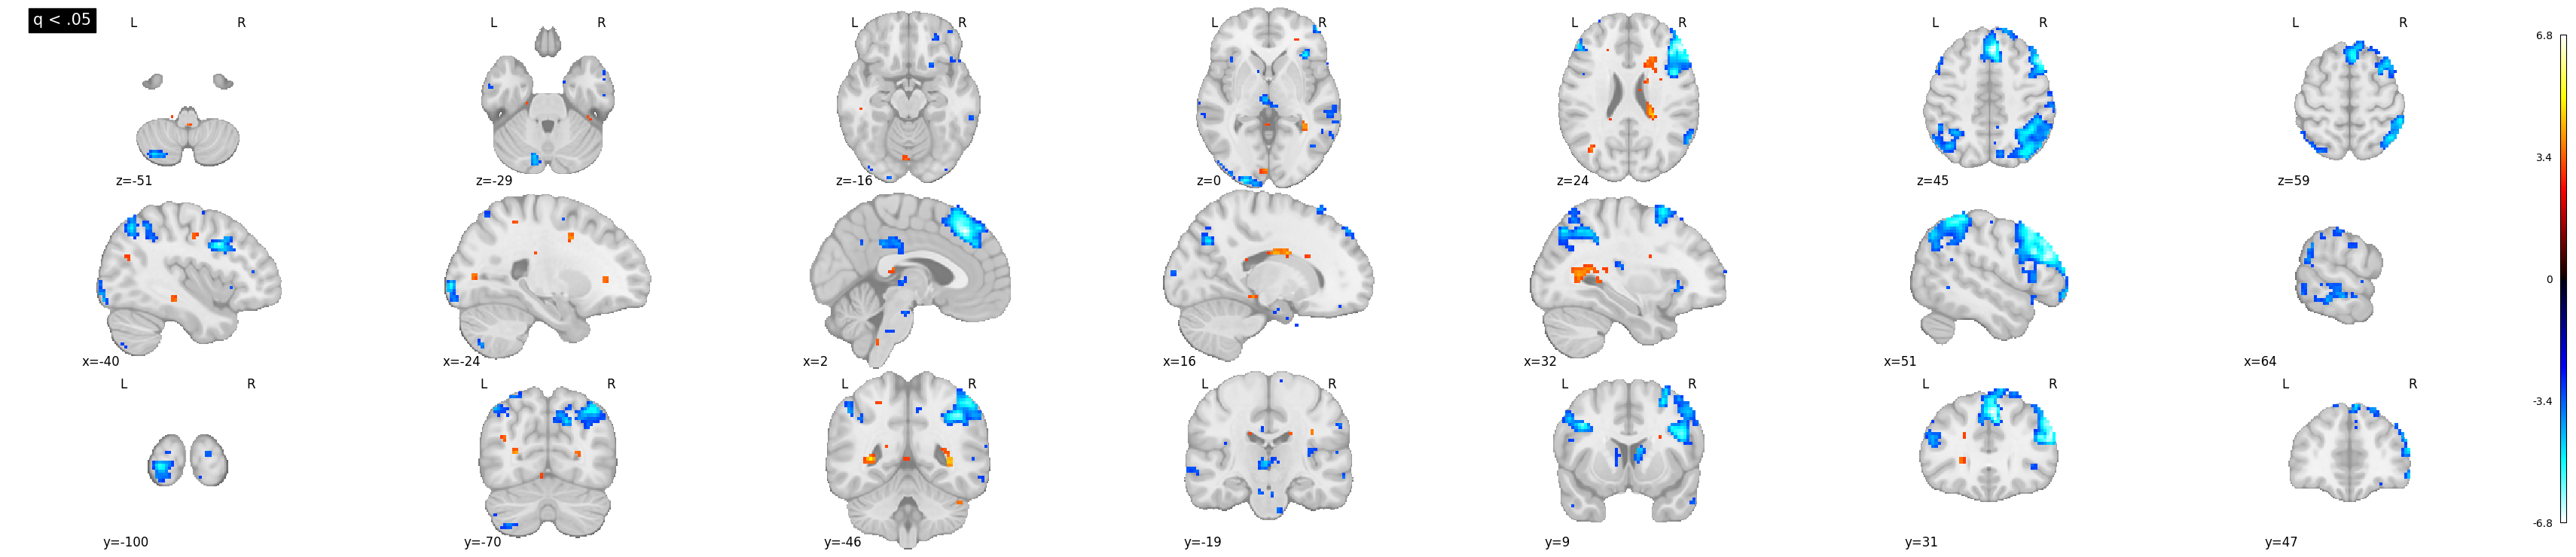

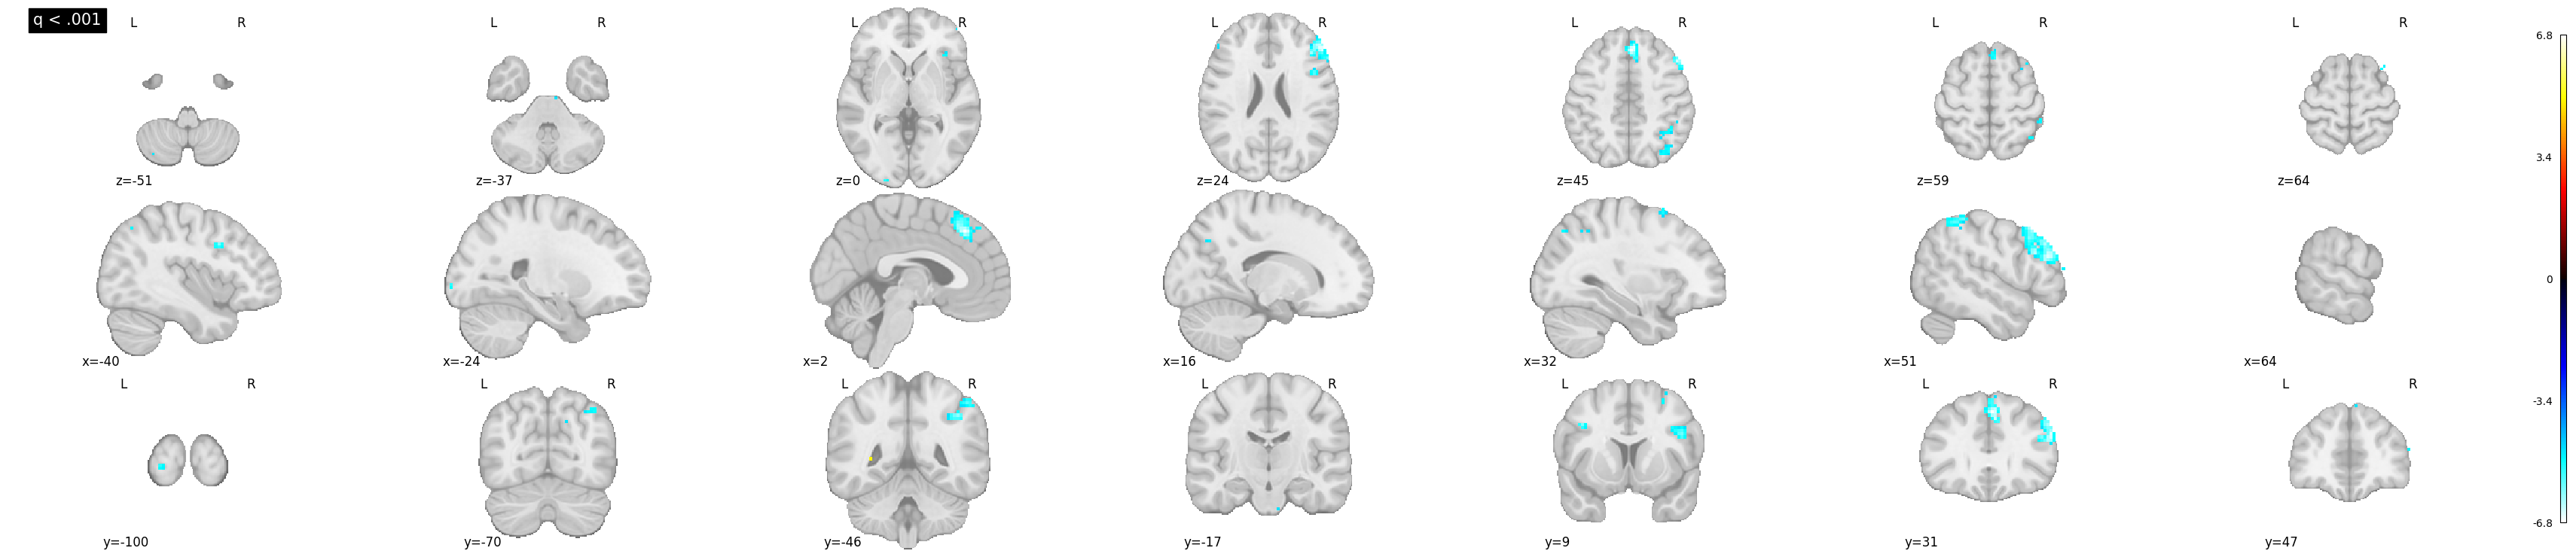

In [27]:
tvalues, pvalues = scipy.stats.ttest_rel(fmri_masked_stimhigh, fmri_masked_stimlow, axis = 0, nan_policy = 'propagate',alternative='two-sided' )
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')

result_map = np.zeros(fmri_masked_stimhigh.shape[1])
result_map[qvalues < .05] = tvalues[qvalues < .05]
con_tmap = nifti_masker.inverse_transform(result_map)

result_map_001 = np.zeros(fmri_masked_stimhigh.shape[1])
result_map_001[qvalues < .001] = tvalues[qvalues < .001]
con_tmap_001 = nifti_masker.inverse_transform(result_map_001)

plotting.plot_stat_map(con_tmap,  display_mode = 'mosaic', title = 'q < .05')
plotting.plot_stat_map(con_tmap_001,  display_mode = 'mosaic', title = 'q < .001')

In [28]:
print(f"min: {np.min(con_tmap.get_fdata())}")
print(f"max: {np.max(con_tmap.get_fdata())}")
print(f"mean: {np.mean(con_tmap.get_fdata())}")

min: -6.787716827923315
max: 5.283440419936453
mean: -0.03871606552255417
